# Social Group Identity

This project explores measures of group identity, focusing on ingroup vs. outgroup identity perceptions. The data come from an independent study I am conducting in the Cognitive Science department. Alumni from four Dartmouth Greek houses, graduating in 1989 through 2019, completed an online survey that involved rating the four houses on nine identity traits. The traits and their definitions, as presented to respondents, are as follows:

<ul>
 <li><strong>party-oriented</strong>: How much a house engages in parties and social events.</li>
 <li><strong>safe</strong>: How secure, respected, and at-ease members and visitors feel in a house.</li>
 <li><strong>service-oriented</strong>: How much a house engages in community service activities.</li>
 <li><strong>diverse</strong>: How heterogeneous a house is in terms of race/ethnicity, socioeconomic status, home country, etc.</li>
 <li><strong>prestigious</strong>: How influential, popular, or desirable a house is.</li>
 <li><strong>athletics-oriented</strong>: How much a house engages in athletic activities.</li>
 <li><strong>conservative</strong>: How politically or socially conservative a house is.</li>
 <li><strong>inclusive</strong>: How welcoming a house is to people of varied backgrounds or identities.</li>
 <li><strong>academics-oriented</strong>: How much a house engages in academic activities.</li>
</ul>

In [1]:
%matplotlib notebook

import re
import numpy as np
import pandas as pd
import hypertools as hyp
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import mutual_info_classif

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Loading and Wrangling Data

Data come from Qualtrics in a very messy CSV. The following blocks are designed to wrangle the data into something usable, allowing for the addition of new traits and/or houses in the future. Ultimately, ratings are compiled into two separate dataframes: one, `grpRatings`, with each row representing one person's rating of one house on every trait; and one, `indRatings`, with each row representing one persons's rating of one house on one trait.

In [2]:
# Load CSV and let pandas use the first row as column labels
master = pd.read_csv("grp id sanitized May 22.csv")
# The second row (first in our df) is verbose column descriptions
# Pull those out separately
colDescs = master.iloc[0]
# Third row is redundant; drop it and the verbose descriptions
master.drop([0, 1], inplace = True)

In [3]:
# Inspect the data to build a lookup table mapping house numbers and traits to actual columns
# (which aren't named meaningfully in the raw data)
ratingsLookup = pd.DataFrame()
for (col, desc) in colDescs.iteritems():
    # Use a regular expression to pull house ID and trait out of column descriptions
    match = re.search(r'^Please rate how well each of the following traits describes House (\d+)\.Note that you may leave rows blank if you have no response\. - ([\w\-\s]+)$', str(desc))
    if match:
        # Add relevant columns to the lookup table
        ratingsLookup = ratingsLookup.append({"HouseID": match.group(1), "Trait": match.group(2), "ColID": col}, ignore_index = True)
ratingsLookup = ratingsLookup.set_index(["HouseID"]).sort_index().sort_values("Trait")

# Do something similar for ratings of the participant's own house (which are labeled slightly differently)
selfRatingsLookup = pd.Series()
# All the relevant columns start with "Q62_"
for col, desc in colDescs[colDescs.index.str.startswith("Q62_")].iteritems():
        # Another regex to pull out the trait
        match = re.search(r'^Please rate how well each of the following traits describe your house, \[Field-houseName]\. - ([\w\-\s]+)$', str(desc))
        if match:
            # Add it to the lookup table
            selfRatingsLookup[col] = match.group(1)

## Valence

One additional step (rolled into the data wrangling for performance reasons) is assigning an overall valence to each row in the `grpRatings` column. This is based on a broad generalization of what the Dartmouth population views as positive, negative, or neutral (visible in the `valences` dictionary). Each trait's valence sign is multiplied by its rating, and all are summed up to form the row's overall valence. This is, again, based on wide generalizations and imperfect. Future studies could approach valence more systematically.

In [4]:
# Now assemble two dataframes of ratings
# In the first, each row is someone's rating of a single house on multiple traits
# In the second, each row is someone's rating of a single house on a single trait
grpRatings = pd.DataFrame()
indRatings = pd.DataFrame()
# Map traits to valences
valences = {"academics-oriented": 0,
            "athletics-oriented": 1,
            "conservative": -1,
            "diverse": 1,
            "inclusive": 1,
            "party-oriented": 1,
            "prestigious": 1,
            "safe": 1,
            "service-oriented": 1}
# Loop over each response
for idx, response in master.iterrows():
    # Loop over each house represented in the lookup table
    for house, lu in ratingsLookup.groupby(level = 0):
        thisHouse = pd.Series()
        valence = 0.0
        # Using the lookup table, grab the actual ratings
        for relCol in lu.iterrows():
            val, trait = response[relCol[1]["ColID"]], relCol[1]["Trait"]
            if pd.notnull(val):
                # Store them in the grouped rating row...
                thisHouse[trait] = val
                # ... and as individual rows
                thisInd = pd.Series({"Trait": trait, "Value": int(val)})
                thisInd["HouseID"] = int(house)
                thisInd["RaterHouseID"] = int(response["House ID"])
                thisInd["ParentRespID"] = int(idx)
                thisInd["Year"] = int(response["gradYear"])
                indRatings = indRatings.append(thisInd, ignore_index = True)
                # Update the running valence total
                valence += float(valences[trait]) * float(val) # why isn't this adding to the existing value?
            valenceRating = pd.Series({"Trait": "Valence", "Value": valence})
            valenceRating["HouseID"] = int(house)
            valenceRating["RaterHouseID"] = int(response["House ID"])
            valenceRating["ParentRespID"] = int(idx)
            valenceRating["Year"] = int(response["gradYear"])
            indRatings = indRatings.append(valenceRating, ignore_index = True)
        # Unless the participant left everything blank for this house,
        # grab metadata and add it to the dataframe
        if not thisHouse.isnull().all():
            thisHouse["HouseID"] = house
            thisHouse["RaterHouseID"] = response["House ID"]
            thisHouse["ParentRespID"] = idx
            thisHouse["Year"] = response["gradYear"]
            thisHouse["Valence"] = valence
            grpRatings = grpRatings.append(pd.to_numeric(thisHouse), ignore_index = True)
    
    # Grab self ratings using the relevant lookup table
    selfRating = pd.Series()
    valence = 0.0
    for col, trait in selfRatingsLookup.iteritems():
        val = response[col]
        if pd.notnull(val):
            # Add trait to grouped...
            selfRating[trait] = val
            # ... and as an individual
            thisInd = pd.Series({"Trait": trait, "Value": int(val)})
            thisInd["HouseID"] = int(response["House ID"])
            thisInd["RaterHouseID"] = int(response["House ID"])
            thisInd["ParentRespID"] = int(idx)
            thisInd["Year"] = int(response["gradYear"])
            indRatings = indRatings.append(thisInd, ignore_index = True)
            # Update the running valence total
            valence += (float(valences[trait]) * float(val))
        valenceRating = pd.Series({"Trait": "Valence", "Value": valence})
        valenceRating["HouseID"] = int(response["House ID"])
        valenceRating["RaterHouseID"] = int(response["House ID"])
        valenceRating["ParentRespID"] = int(idx)
        valenceRating["Year"] = int(response["gradYear"])
        indRatings = indRatings.append(valenceRating, ignore_index = True)
    # Unless the participant left everything blank, add it to the list
    if not selfRating.isnull().all():
            selfRating["HouseID"] = response["House ID"]
            selfRating["RaterHouseID"] = response["House ID"]
            selfRating["ParentRespID"] = idx
            selfRating["Year"] = response["gradYear"]
            selfRating["Valence"] = valence
    grpRatings = grpRatings.append(pd.to_numeric(selfRating), ignore_index = True)

## Descriptive Stats

Averages and standard deviations, both overall and grouped by house.

In [5]:
# Overall Means
grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year"]).mean()

HouseID                2.488000
Valence               17.604000
academics-oriented     2.788079
athletics-oriented     2.093817
conservative           1.711207
diverse                2.923890
inclusive              3.472689
party-oriented         3.523517
prestigious            2.473904
safe                   3.334029
service-oriented       2.363436
dtype: float64

In [6]:
# Means by House
grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year"]).groupby("HouseID").mean()

,Valence,academics-oriented,athletics-oriented,conservative,diverse,inclusive,party-oriented,prestigious,safe,service-oriented
HouseID,,,,,,,,,,
1.0,18.763780,3.400000,1.170732,1.132231,3.879032,4.528000,2.360000,1.504000,4.354839,2.571429
2.0,16.672131,3.146789,2.578947,2.303571,2.324561,3.017699,3.739496,2.767241,3.051724,2.495413
3.0,15.610687,1.922414,1.819672,1.775000,2.583333,2.943548,4.276923,2.609756,2.322581,1.675214
4.0,19.500000,2.675926,2.927273,1.675676,2.843478,3.342105,3.713043,3.086957,3.608696,2.743119


<IPython.core.display.Javascript object>


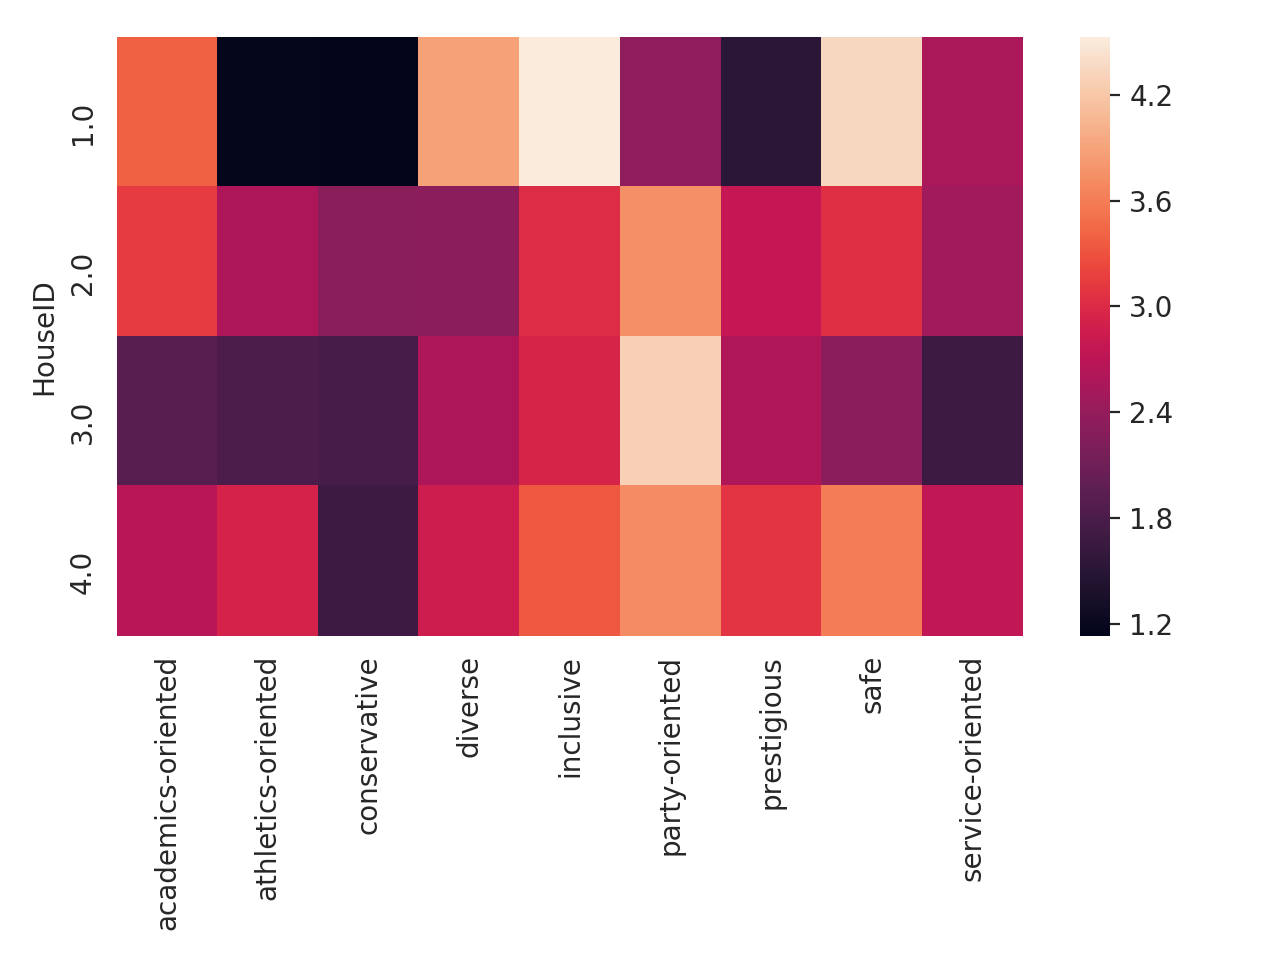

In [25]:
%matplotlib notebook
# Heatmap of Means by House
sns.heatmap(grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year", "Valence"]).groupby("HouseID").mean())
plt.tight_layout()
plt.show()

In [8]:
# Oveall Standard Deviations
grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year"]).std()

HouseID               1.113704
Valence               5.268653
academics-oriented    1.106753
athletics-oriented    1.130267
conservative          0.974072
diverse               1.263285
inclusive             1.241938
party-oriented        1.197658
prestigious           1.116090
safe                  1.295757
service-oriented      1.028333
dtype: float64

In [9]:
# Standard Deviations by House
grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year"]).groupby("HouseID").std()

,Valence,academics-oriented,athletics-oriented,conservative,diverse,inclusive,party-oriented,prestigious,safe,service-oriented
HouseID,,,,,,,,,,
1.0,3.853378,0.920358,0.491023,0.427047,1.000754,0.757500,1.027053,0.736426,0.828296,0.934929
2.0,4.908152,1.128960,0.976672,0.994030,0.991072,1.101803,0.906307,0.981195,1.148495,1.005760
3.0,4.940527,0.845971,0.927241,1.040867,1.240651,1.142686,0.853769,1.098689,1.040234,0.796859
4.0,6.260453,0.894727,1.130958,0.945440,1.210997,1.210784,1.049354,0.923050,1.182442,1.031034


<IPython.core.display.Javascript object>


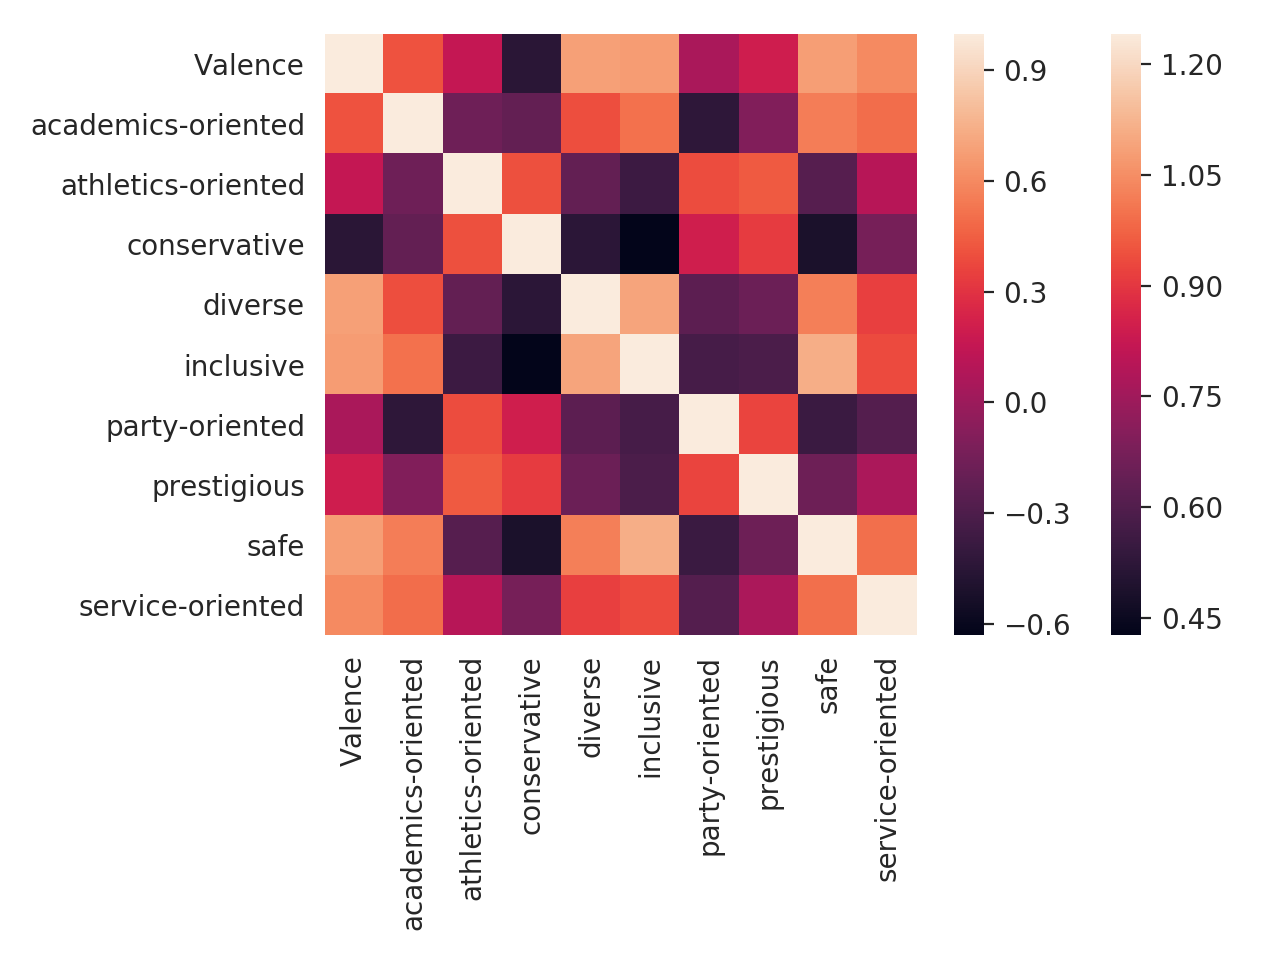

In [26]:
# Heatmap of Standard Deviations by House
%matplotlib notebook
sns.heatmap(grpRatings.drop(columns = ["ParentRespID", "RaterHouseID", "Year", "Valence"]).groupby("HouseID").std())
plt.tight_layout()
plt.show()

In [11]:
# Correlations
grpRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year"]).corr()

,Valence,academics-oriented,athletics-oriented,conservative,diverse,inclusive,party-oriented,prestigious,safe,service-oriented
Valence,1.000000,0.413591,0.157325,-0.449935,0.682986,0.673315,0.050793,0.201012,0.680259,0.598755
academics-oriented,0.413591,1.000000,-0.166875,-0.212849,0.394851,0.511594,-0.430603,-0.099696,0.554647,0.497713
athletics-oriented,0.157325,-0.166875,1.000000,0.401399,-0.214706,-0.371564,0.391406,0.434787,-0.262426,0.102695
conservative,-0.449935,-0.212849,0.401399,1.000000,-0.444944,-0.631345,0.205842,0.332917,-0.516094,-0.140291
diverse,0.682986,0.394851,-0.214706,-0.444944,1.000000,0.705952,-0.240773,-0.179609,0.565171,0.348100
inclusive,0.673315,0.511594,-0.371564,-0.631345,0.705952,1.000000,-0.325853,-0.310340,0.742219,0.386755
party-oriented,0.050793,-0.430603,0.391406,0.205842,-0.240773,-0.325853,1.000000,0.367106,-0.378299,-0.273353
prestigious,0.201012,-0.099696,0.434787,0.332917,-0.179609,-0.310340,0.367106,1.000000,-0.177801,0.062276
safe,0.680259,0.554647,-0.262426,-0.516094,0.565171,0.742219,-0.378299,-0.177801,1.000000,0.503955
service-oriented,0.598755,0.497713,0.102695,-0.140291,0.348100,0.386755,-0.273353,0.062276,0.503955,1.000000


<IPython.core.display.Javascript object>


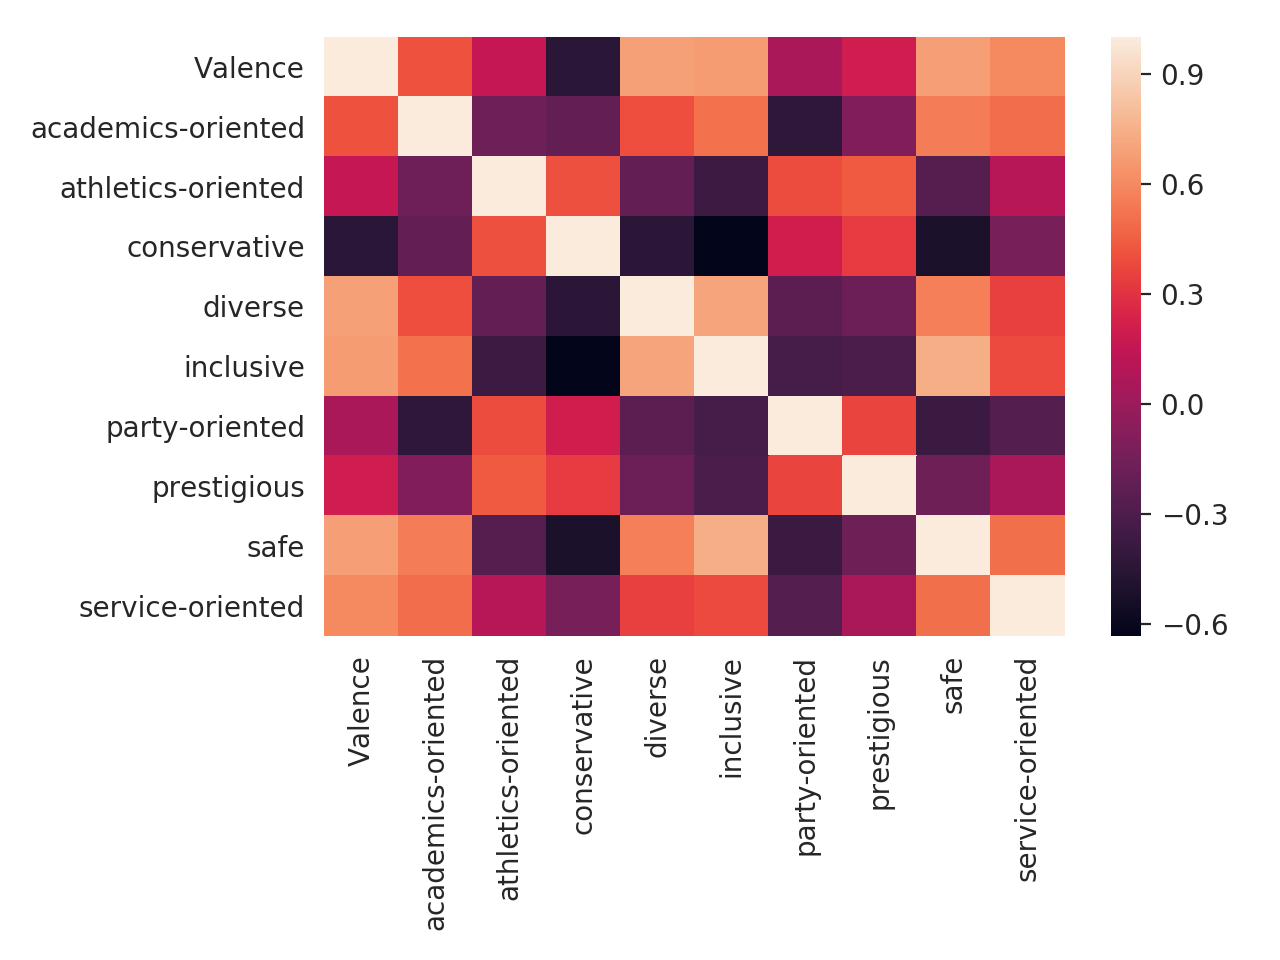

In [28]:
%matplotlib notebook
# Heatmap of Correlations
sns.heatmap(grpRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year"]).corr())
plt.tight_layout()
plt.show()

## Inferential Stats

Do members of a given group rate that group significantly more positively than others do?

In [13]:
inGroupValences = pd.DataFrame(grpRatings.loc[grpRatings["RaterHouseID"] == grpRatings["HouseID"]].groupby("HouseID").mean()["Valence"].reset_index())
outGroupValences = pd.DataFrame(grpRatings.loc[grpRatings["RaterHouseID"] != grpRatings["HouseID"]].groupby("HouseID").mean()["Valence"].reset_index())
scipy.stats.ttest_ind(inGroupValences["Valence"], outGroupValences["Valence"])

Ttest_indResult(statistic=3.41011964282322, pvalue=0.014316532813772043)

Yes, p = 0.01.

## Rating Visualizations

Sure enough, ingroup members rate higher valence than outgroup members.

<IPython.core.display.Javascript object>


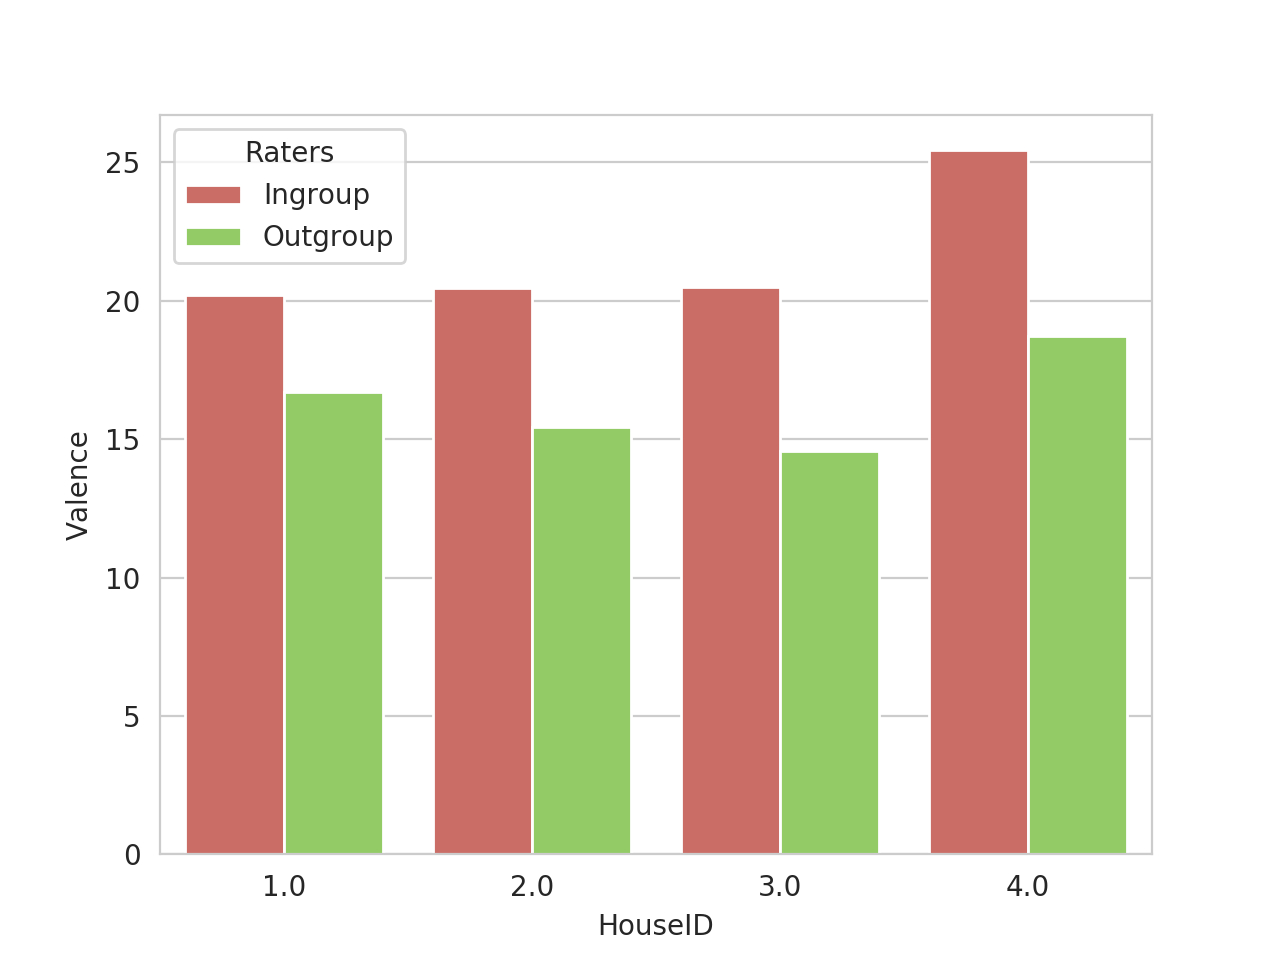

In [29]:
%matplotlib notebook
# Plot of Ingroup vs Outgroup Valence by House
inGroupValences["Raters"] = "Ingroup"
outGroupValences["Raters"] = "Outgroup"
meanValences = pd.concat(objs = [inGroupValences, outGroupValences], ignore_index = True)
sns.barplot(data = meanValences, x = "HouseID", y = "Valence", hue = "Raters")

Some houses appear to be rated in the middle on most traits (e.g. Houses 2 and 4). One appears very high on some traits and very low on others (House 1). One appears low on most traits but very high on one (House 3).

<IPython.core.display.Javascript object>


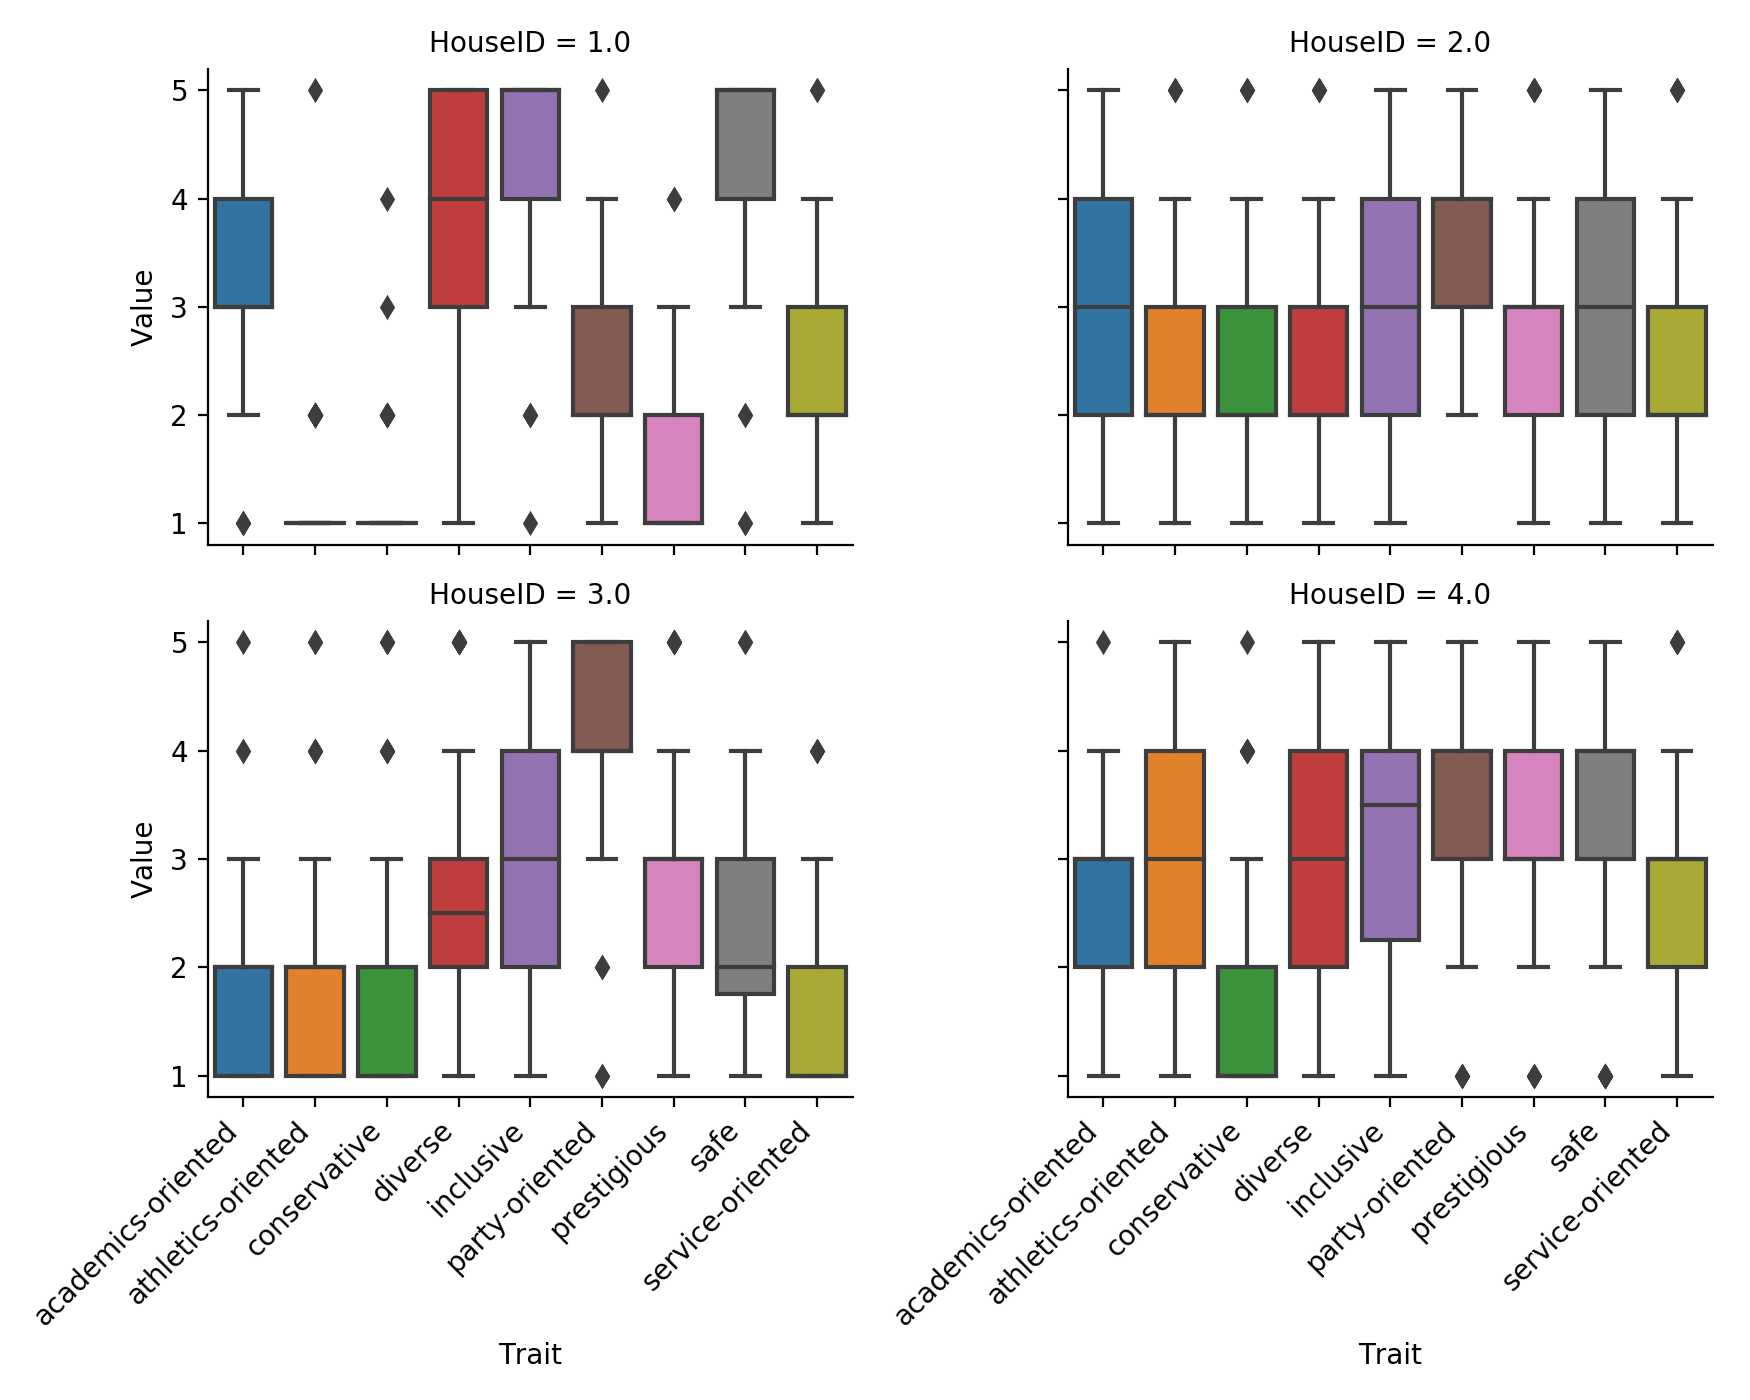

In [15]:
# Plots, Grouped by House
boxByHouse = sns.catplot(kind = "box", data = indRatings[indRatings["Trait"] != "Valence"], x = "Trait", y = "Value", col = "HouseID", col_wrap = 2, height = 3.5, aspect = 1.25)
boxByHouse.set_xticklabels(rotation = 45, ha = "right")
boxByHouse.set(yticks = list(range(1,6))) 
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


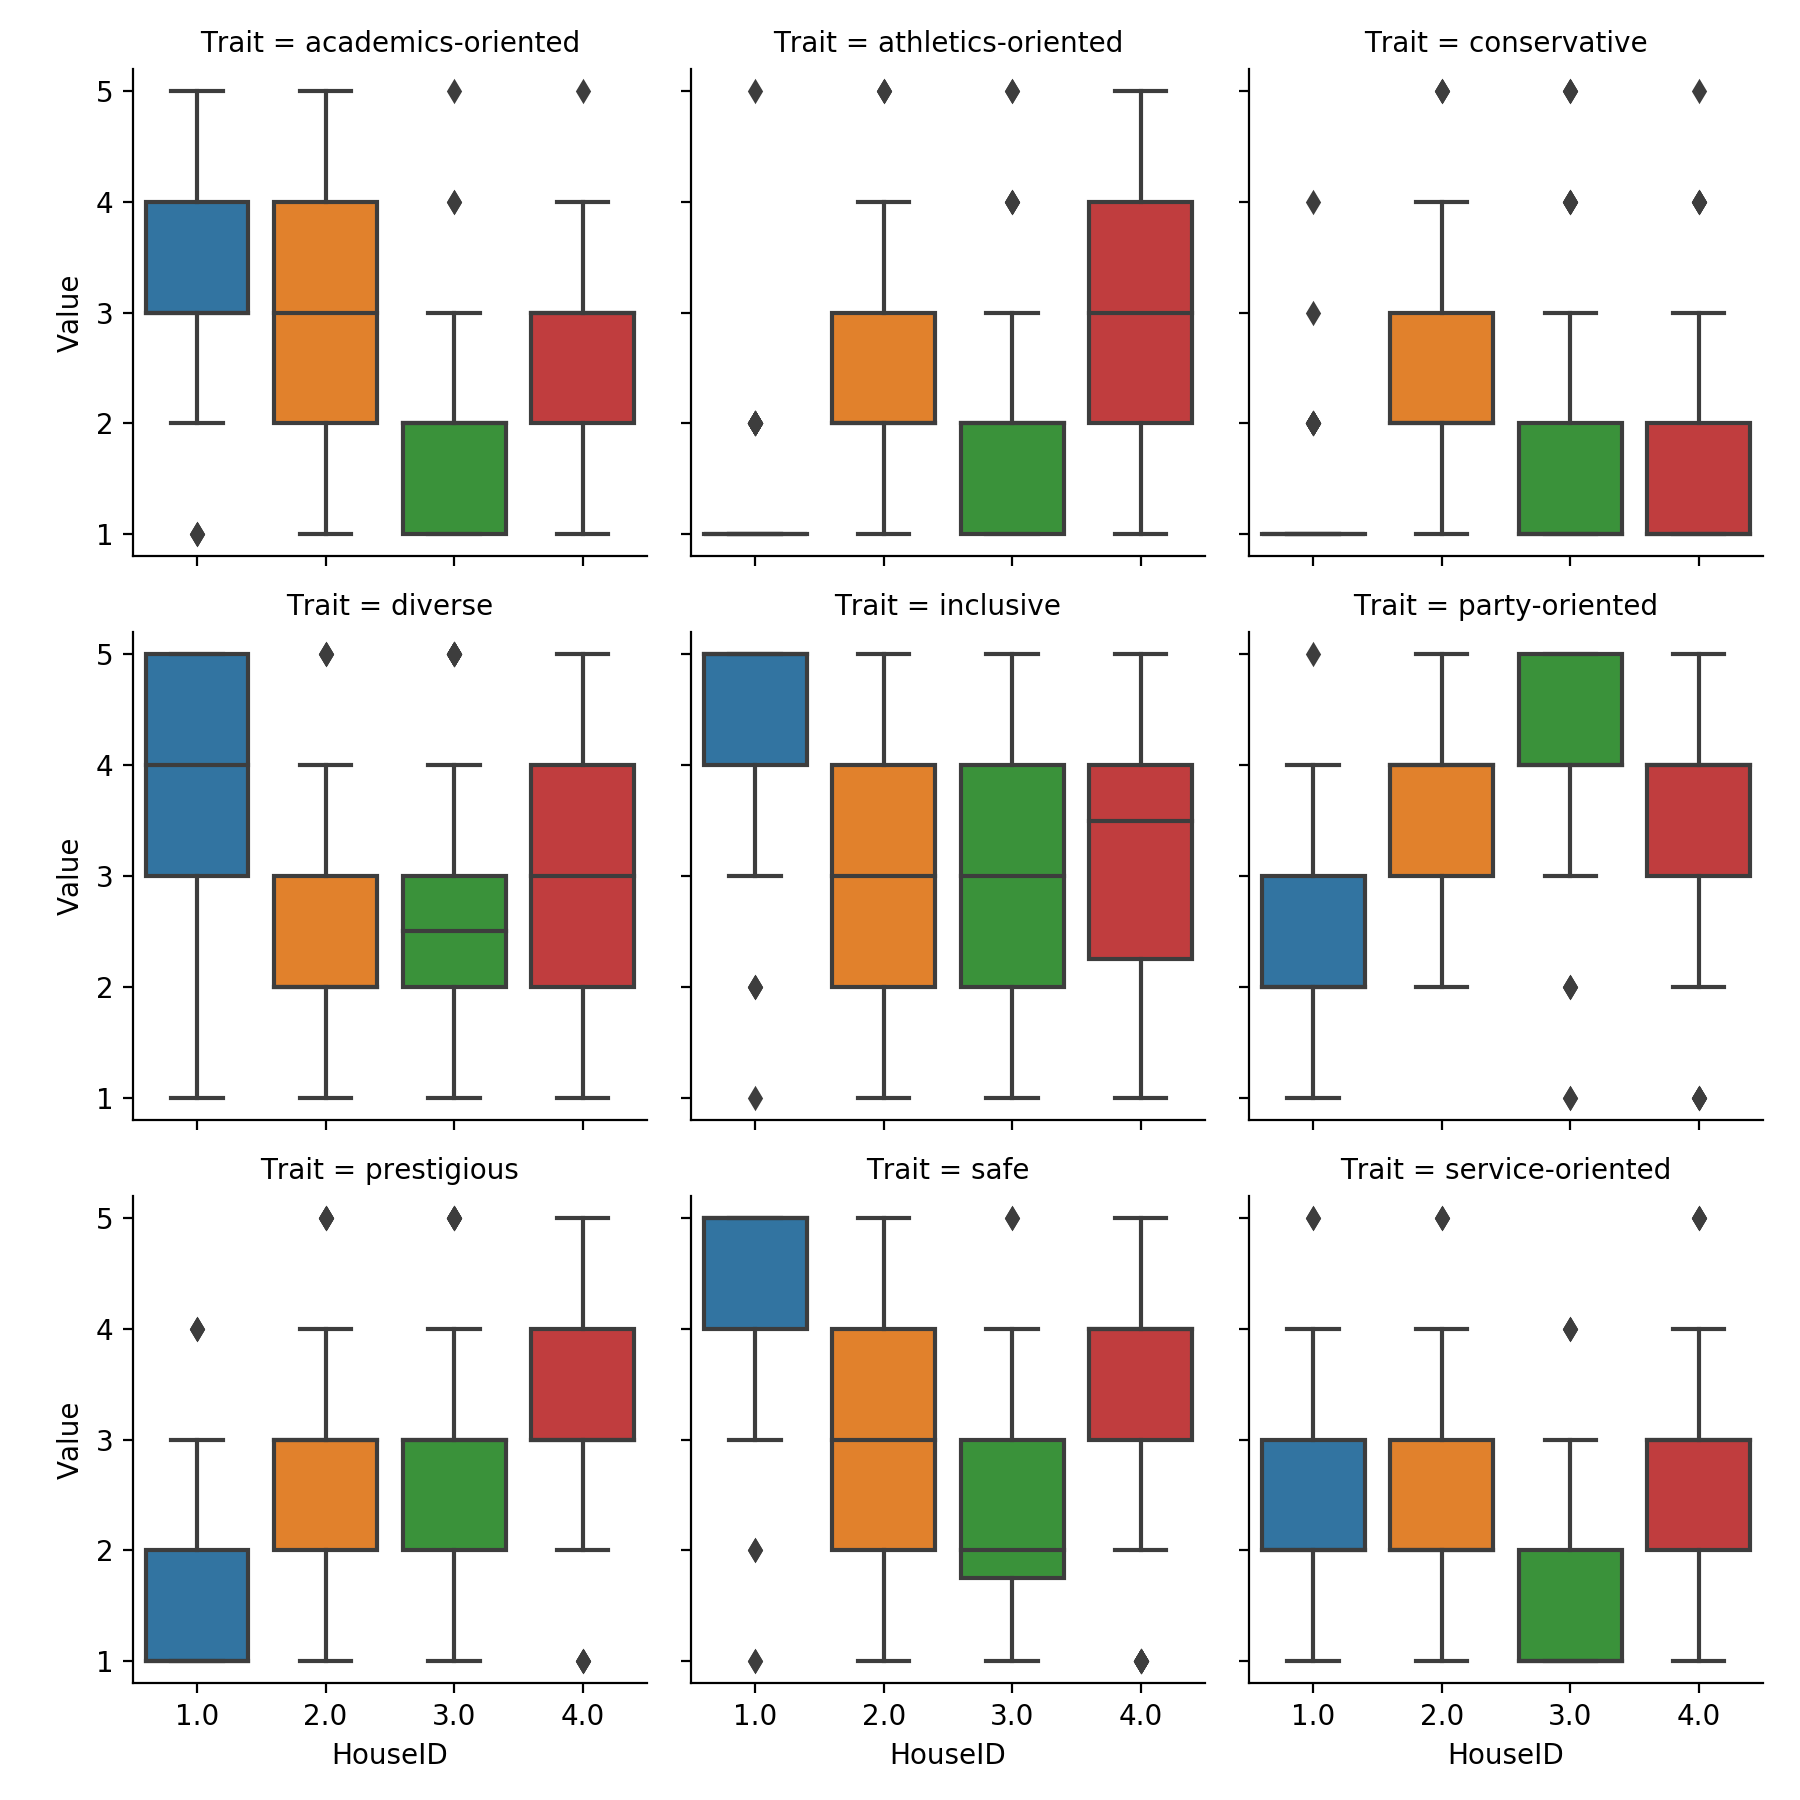

In [16]:
# Plots, Grouped by Trait
boxByTrait = sns.catplot(x = "HouseID", y = "Value", col = "Trait", col_wrap = 3, data = indRatings[indRatings["Trait"] != "Valence"], kind = "box", height = 3)
boxByTrait.set(yticks = list(range(1,6))) 
plt.show()

Some interesting differences emerge in ingroup vs outgroup ratings. Some ratings appear fairly universal; e.g., there is high agreement that House 1 is *safe*. However, House 3, the highest-rated house on the *party-oriented* trait, consistently rates other houses as less party-oriented than those houses rate themselves. Similalry, House 1, the highest-rated house on the *diverse* trait, rates other houses as less diverse than those hosues rate themselves. This might suggest that people are making some judgements at least in part by comparing other groups to some baseline informed by their own group's identity.

<IPython.core.display.Javascript object>


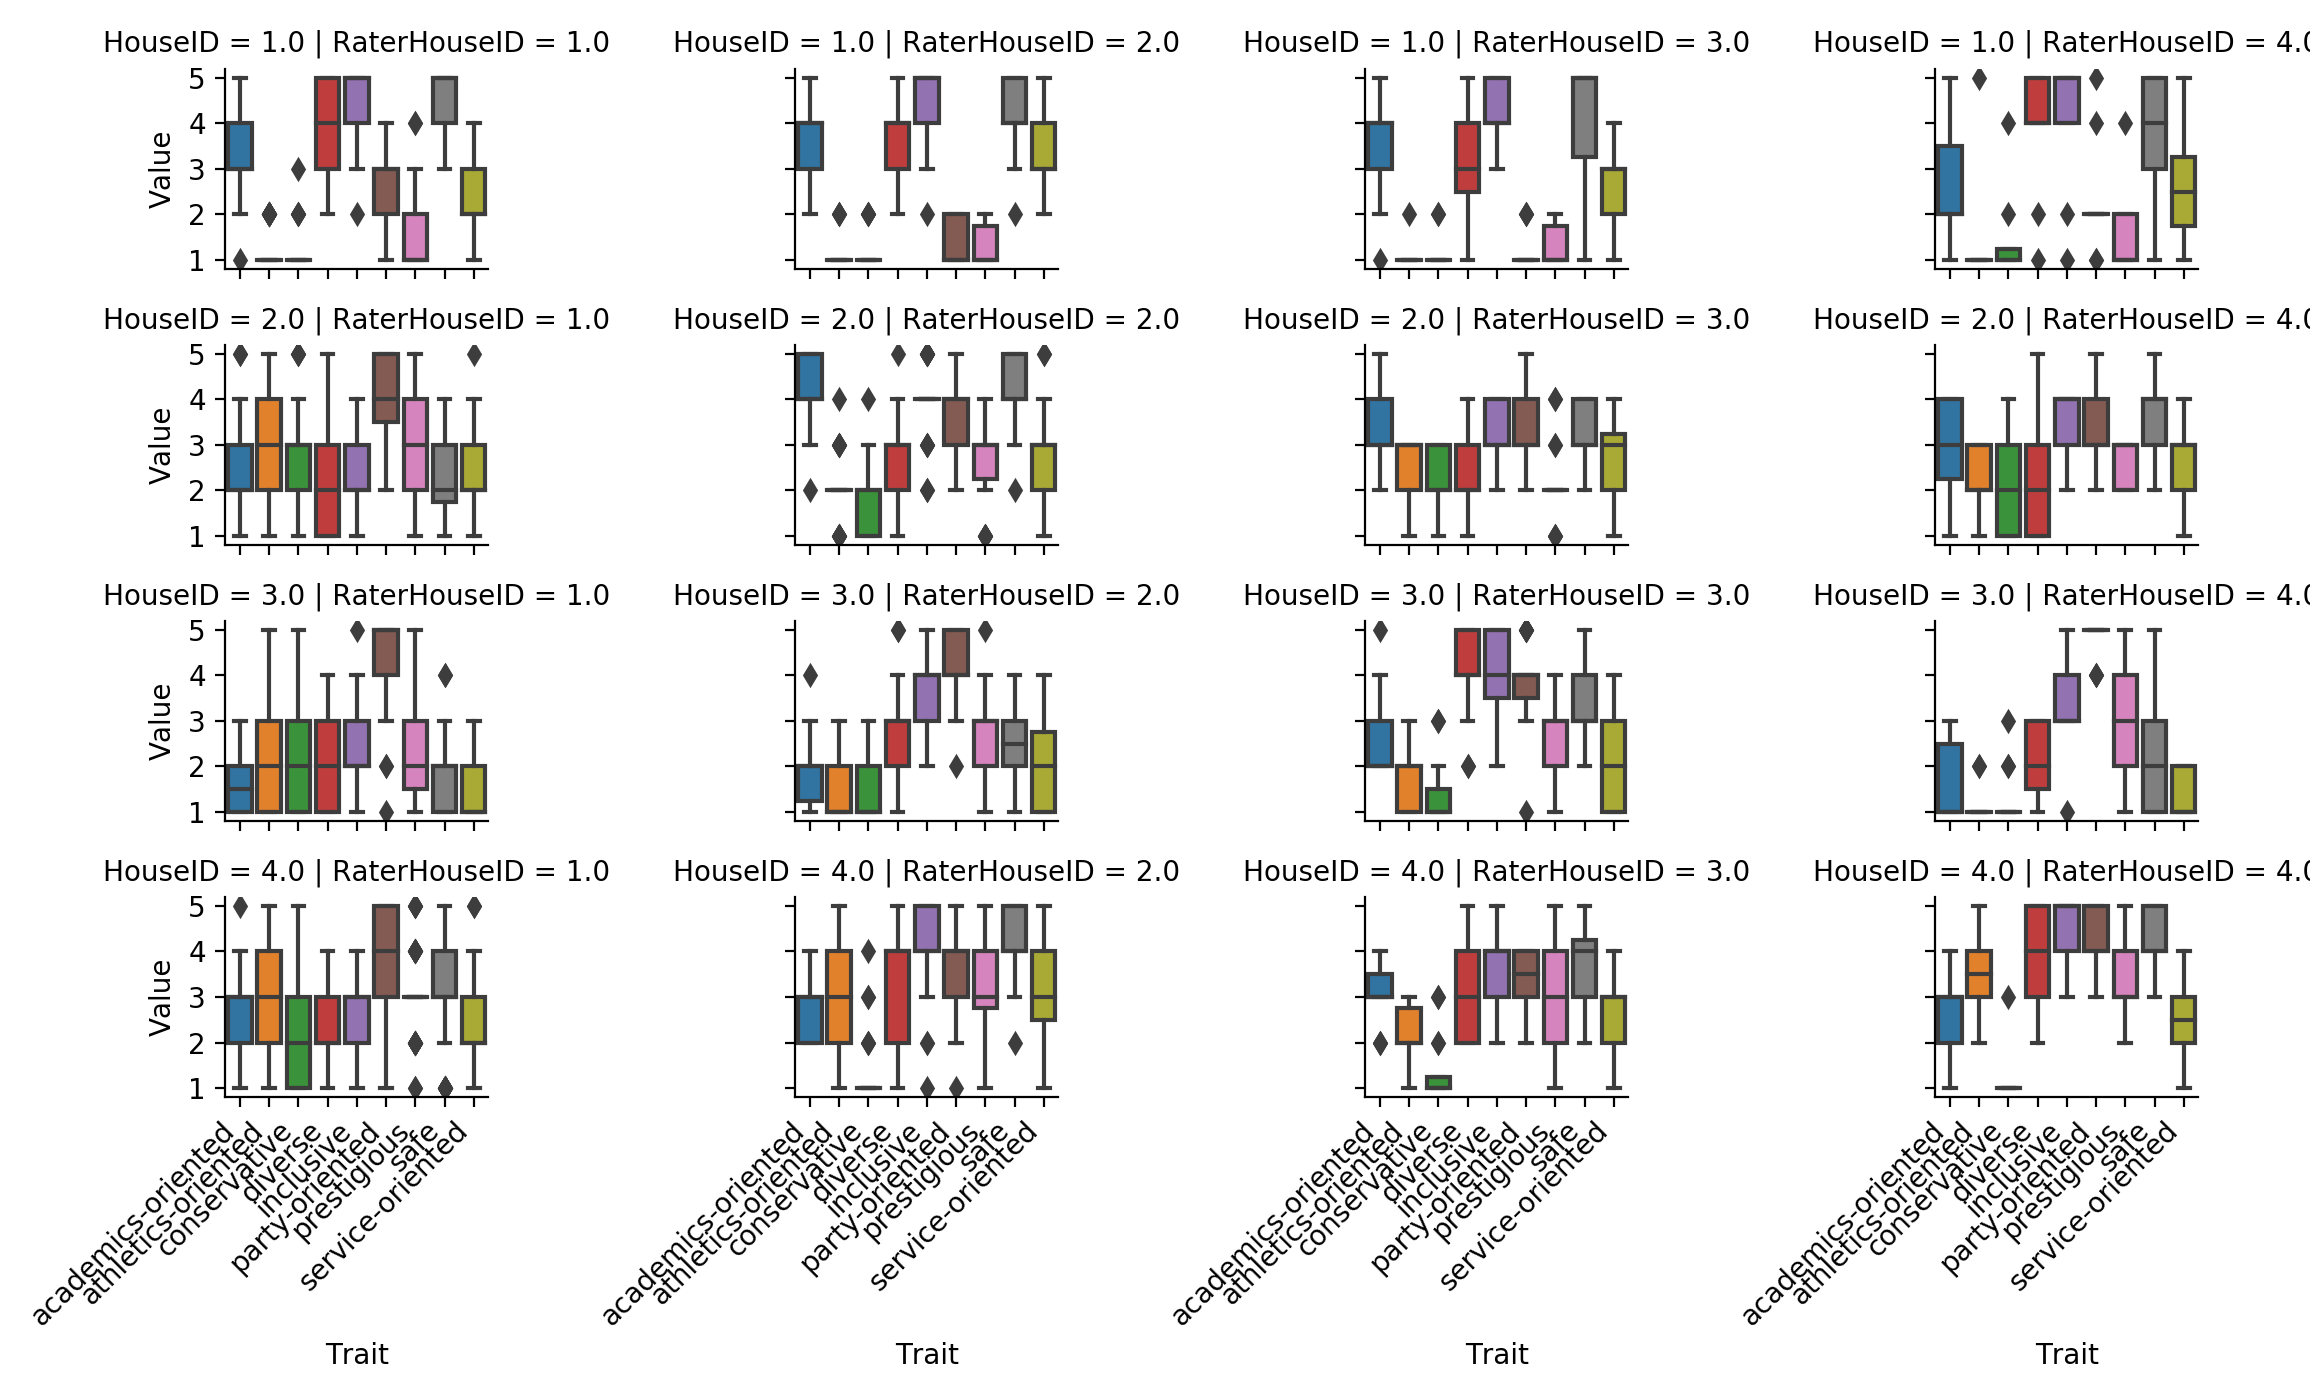

In [17]:
# Plots; Row = House Rated, Col = Rater's House
inVsOut = sns.catplot(kind = "box", data = indRatings[indRatings["Trait"] != "Valence"], x = "Trait", y = "Value", col = "RaterHouseID", row = "HouseID", height = 1.75, aspect = 1.65)
for axis in inVsOut.axes[-1]:
    axis.set_xticklabels(axis.get_xticklabels(), ha = "right", rotation = 45)
inVsOut.set(yticks = list(range(1,6)))
plt.tight_layout()
plt.show()

## Clustering and Predicting

A Hypertools plot to look for clusters. Although there is a decent amount of overlap, spatial trends do emerge.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning: Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)
  warnings.warn('Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)')


<IPython.core.display.Javascript object>


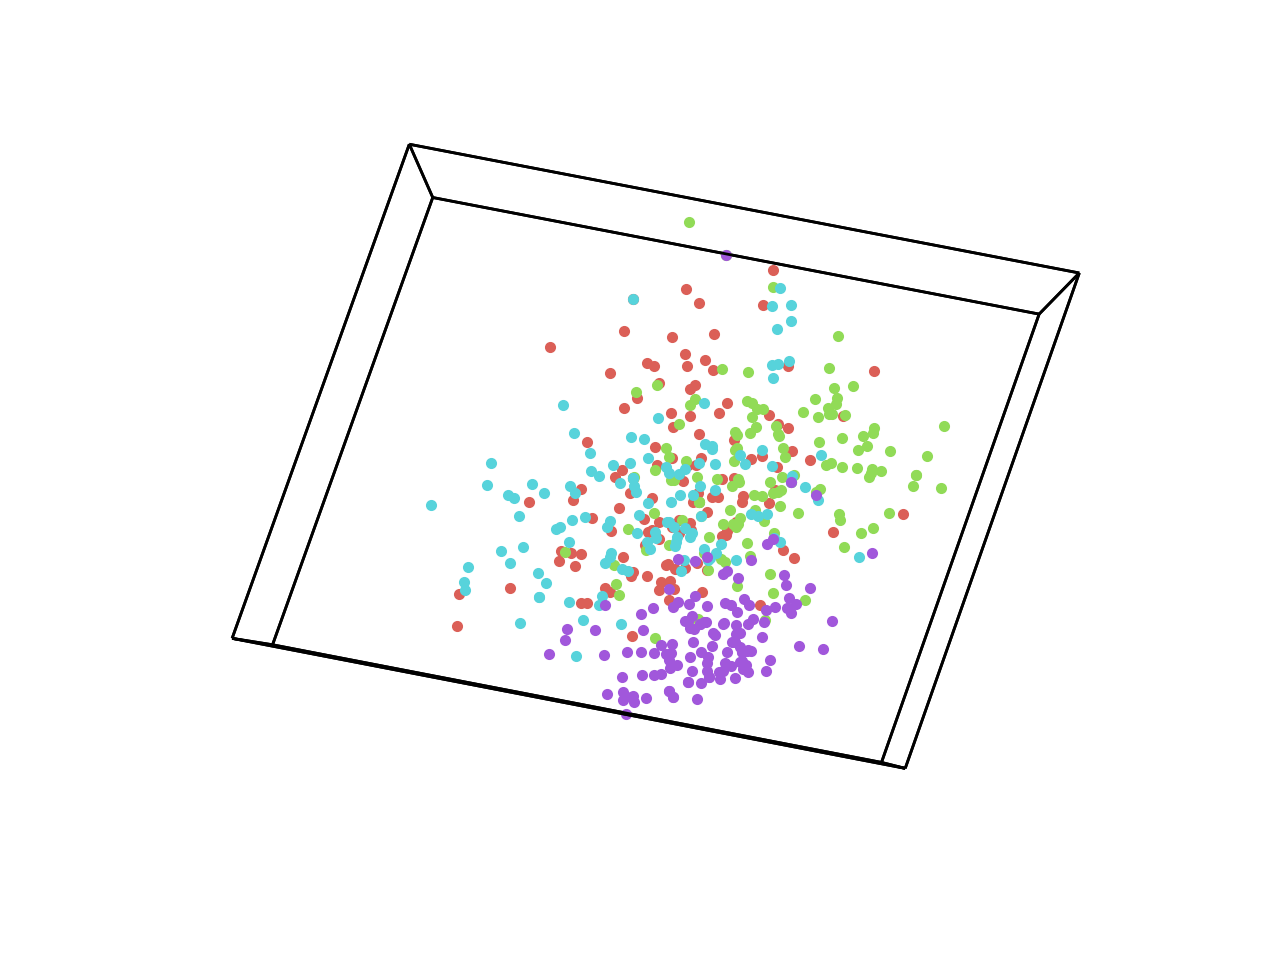

In [30]:
hyp.plot(grpRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year", "Valence"]), ".", hue = grpRatings["HouseID"])

A similar distribution emerges when filtering to data from the past 4 years.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning: Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)
  warnings.warn('Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)')


<IPython.core.display.Javascript object>


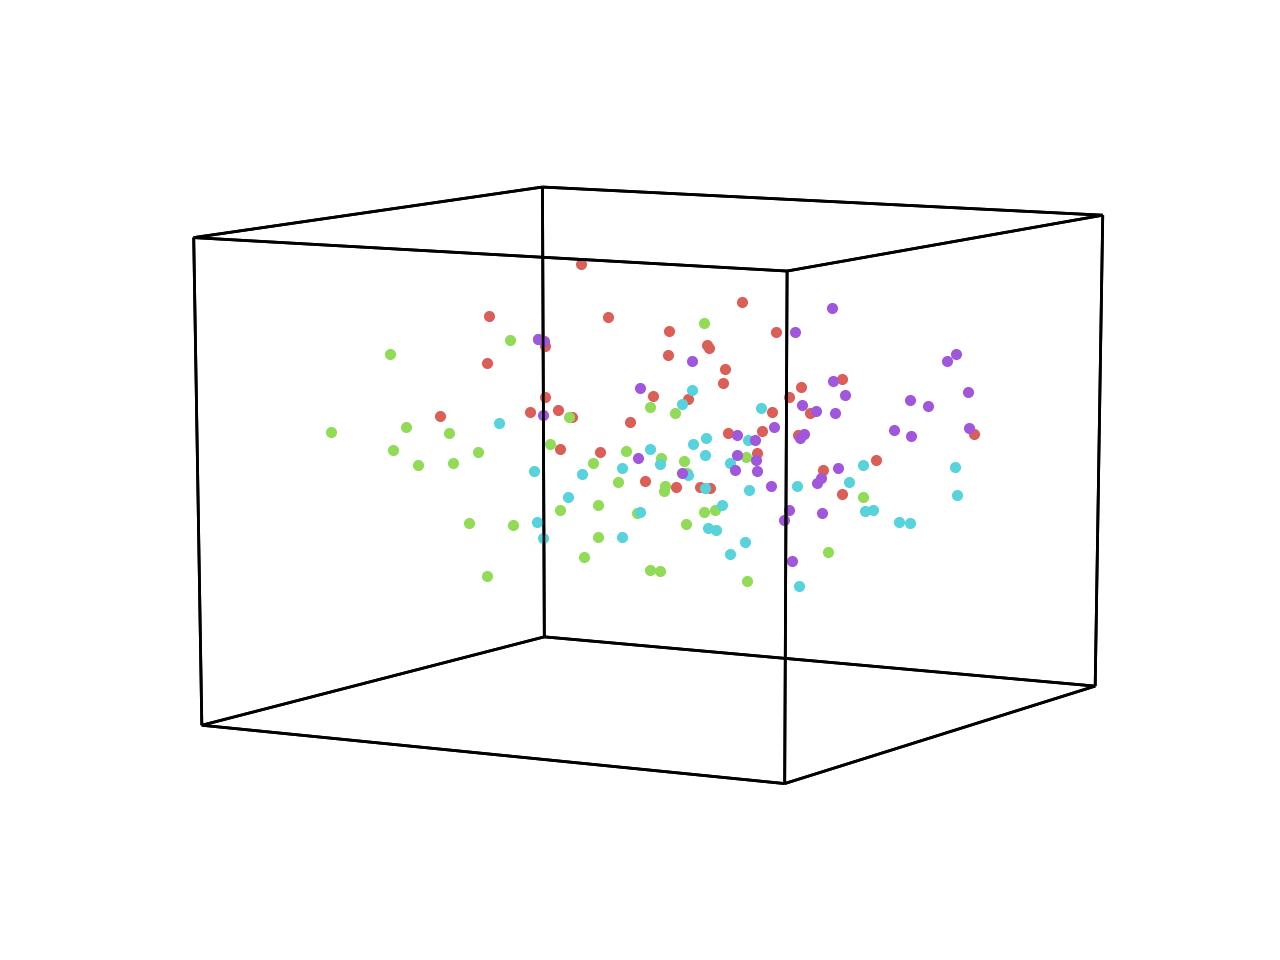

In [19]:
recentRatings = grpRatings.loc[grpRatings["Year"] > 2015]
hyp.plot(recentRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year", "Valence"]), ".", hue = recentRatings["HouseID"])

Can a model predict which house is being rated based on the ratings and the rater's house?

In [20]:
# Based on rating values and the rater's house, can we predict which house they were rating?
# > A decent amount. Interesting: slight performance hit by including year.

# Use 75% of the data to train and 25% to test
testFrac = 0.25
# Repeat five times, because model performance varies a bit
for i in list(range(5)):
    # Drop everything that isn't weather data
    reducedData = pd.DataFrame(hyp.reduce(grpRatings.drop(columns = ["HouseID", "ParentRespID", "Year"]), ndims=8, reduce='UMAP'))
    # Split test and train data
    testIn = pd.DataFrame(reducedData.sample(frac = testFrac))
    trainIn = pd.DataFrame(reducedData.drop(testIn.index))
    testOut = pd.DataFrame(grpRatings.loc[testIn.index]["HouseID"])
    trainOut = pd.DataFrame(grpRatings.loc[trainIn.index]["HouseID"])
    # Drop nulls
    testDrop = testOut[testOut.isnull().any(1)].index.values
    trainDrop = trainOut[trainOut.isnull().any(1)].index.values
    testIn.drop(testDrop, inplace = True)
    testOut.drop(testDrop, inplace = True)
    trainIn.drop(trainDrop, inplace = True)
    trainOut.drop(trainDrop, inplace = True)
    # Build and train the model
    model = MLPRegressor(solver = "lbfgs", alpha = 1e-5, hidden_layer_sizes = (20, 20, 20)).fit(trainIn, trainOut["HouseID"].values)
    # Test the model and print out the score
    print(model.score(testIn, testOut["HouseID"].values))

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning: Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)
  warnings.warn('Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)')


0.5411282382752631
0.578708637161911
0.563138702599581
0.5954359228099433
0.5469916931741194


Yes, the model predicts ~50% of the variance (twice as good as chance with four houses).

Can a model predict what house a rater belongs to based on their ratings of a given house?

In [21]:
# Based on rating values and the house they referred to, can we predict the rater's house?
# > Not really. Interesting: slight performance bump by including year.

# Use 75% of the data to train and 25% to test
testFrac = 0.25
# Repeat five times, because model performance varies a bit
for i in list(range(5)):
    # Drop everything that isn't weather data
    reducedData = pd.DataFrame(hyp.reduce(grpRatings.drop(columns = ["RaterHouseID", "ParentRespID"]), ndims=8, reduce='UMAP'))
    # Split test and train data
    testIn = pd.DataFrame(reducedData.sample(frac = testFrac))
    trainIn = pd.DataFrame(reducedData.drop(testIn.index))
    testOut = pd.DataFrame(grpRatings.loc[testIn.index]["RaterHouseID"])
    trainOut = pd.DataFrame(grpRatings.loc[trainIn.index]["RaterHouseID"])
    # Drop nulls
    testDrop = testOut[testOut.isnull().any(1)].index.values
    trainDrop = trainOut[trainOut.isnull().any(1)].index.values
    testIn.drop(testDrop, inplace = True)
    testOut.drop(testDrop, inplace = True)
    trainIn.drop(trainDrop, inplace = True)
    trainOut.drop(trainDrop, inplace = True)
    # Build and train the model
    model = MLPRegressor(solver = "lbfgs", alpha = 1e-5, hidden_layer_sizes = (20, 20, 20)).fit(trainIn, trainOut["RaterHouseID"].values)
    # Test the model and print out the score
    print(model.score(testIn, testOut["RaterHouseID"].values))

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()
/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning: Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)
  warnings.warn('Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)')


0.2834262275489825
0.184427058952095
0.16089343214569307
0.11909869281652019
0.1258625707254888


Nope!

Finally, which traits contain the highest mutual information as compared to House ID (i.e. the most predictive power)?

In [22]:
imp = IterativeImputer()
filledRatings = pd.DataFrame(imp.fit_transform(grpRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year"])))
print(grpRatings.drop(columns = ["HouseID", "ParentRespID", "RaterHouseID", "Year"]).columns.values)
mutual_info_classif(filledRatings, grpRatings["HouseID"])

['Valence' 'academics-oriented' 'athletics-oriented' 'conservative'
 'diverse' 'inclusive' 'party-oriented' 'prestigious' 'safe'
 'service-oriented']


array([0.14516849, 0.13902138, 0.26057945, 0.11778762, 0.14887729,
       0.16948168, 0.17814549, 0.17618921, 0.22047105, 0.06965855])

## Conclusion

This project explores measures of group identity, focusing on ingroup vs. outgroup identity perceptions. Some of the trends that emerge seem consistent with common intuitions concerning social groups, e.g. that groups view themselves more positively than outsiders do, and that members of groups very high on a trait rate other groups as lower on that trait than that group itself does.